In [ ]:
import os

os.system("pip install kaggle -q")

! pip install node2vec

! pip install optuna

!pip install -q kaggle

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets list

!pip install pyarrow
!pip install boto3

mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 4, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.11/dist-packages/kaggle/__init__.py", line 6, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 434, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.1/140.1 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 122.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 kB 7.1 MB/s e

In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

import pyarrow as pa
import polars as pl

from torchvision import datasets
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision.utils import save_image
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import itertools
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import random

from botocore.client import Config
import boto3
import json
import pyarrow.parquet as pq

In [ ]:
class YandexOSS:
    def __init__(self, key_id, secret, region='ru-central1'):
        endpoint = "https://storage.yandexcloud.net"
        session = boto3.Session(
            aws_access_key_id=key_id,
            aws_secret_access_key=secret,
            region_name=region,
        )
        self.s3 = session.client(
            "s3", endpoint_url=endpoint,
            config=Config(signature_version="s3v4")
        )

    def upload(self, bucket, key, filename):
        self.s3.upload_file(Filename=filename, Bucket=bucket, Key=key)

    def update(self, bucket, key, filename):
        self.upload(bucket, key, filename)

    def update_metadata(self, bucket, key, metadata: dict):
        self.s3.copy_object(
            Bucket=bucket,
            CopySource={'Bucket': bucket, 'Key': key},
            Key=key,
            Metadata=metadata,
            MetadataDirective='REPLACE'
        )

    def presigned_put(self, bucket, key, expires=600):
        return self.s3.generate_presigned_url(
            ClientMethod='put_object',
            Params={'Bucket': bucket, 'Key': key},
            ExpiresIn=expires
        )

    def read_object(self, bucket, key, as_text=True):
        """
        Читает объект в памяти, без сохранения на диск.
        """
        response = self.s3.get_object(Bucket=bucket, Key=key)
        body = response['Body'].read()
        return body.decode('utf-8') if as_text else body

    def download(self, bucket, key, filename):
        """
        Скачивает объект и сохраняет как файл.
        """
        self.s3.download_file(Bucket=bucket, Key=key, Filename=filename)


In [ ]:
os.system("mkdir ~/.kaggle")
os.system("cp kaggle.json ~/.kaggle/")
os.system("chmod 600 ~/.kaggle/kaggle.json")

0

In [ ]:
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

try:
    file_list = api.competition_list_files('aeroclub-recsys-2025').files
    for f in file_list:
        print(f"⬇️  Скачивание {f.name} ...")
        api.competition_download_file('aeroclub-recsys-2025', f.name, path='./data')
    print("✅ Все файлы загружены по отдельности в ./data")
except Exception as e:
    print("❌ Ошибка при скачивании:", e)


⬇️  Скачивание jsons_raw.tar.kaggle ...


100%|██████████| 4.34G/4.34G [01:32<00:00, 50.5MB/s]



⬇️  Скачивание jsons_structure.md ...


100%|██████████| 7.56k/7.56k [00:00<00:00, 13.8MB/s]


⬇️  Скачивание sample_submission.parquet ...


100%|██████████| 68.9M/68.9M [00:00<00:00, 1.00GB/s]


⬇️  Скачивание test.parquet ...


100%|██████████| 137M/137M [00:00<00:00, 1.14GB/s]


⬇️  Скачивание train.parquet ...


100%|██████████| 377M/377M [00:01<00:00, 383MB/s]


✅ Все файлы загружены по отдельности в ./data


In [ ]:
! kaggle datasets download samvelkoch/global-airports-iata-icao-timezone-geo

Dataset URL: https://www.kaggle.com/datasets/samvelkoch/global-airports-iata-icao-timezone-geo
License(s): MIT
  0% 0.00/240k [00:00<?, ?B/s]
100% 240k/240k [00:00<00:00, 506MB/s]


In [ ]:
! unzip global-airports-iata-icao-timezone-geo

Archive:  global-airports-iata-icao-timezone-geo.zip
  inflating: airports.csv            


In [ ]:
airports = pd.read_csv("airports.csv")

In [ ]:
airports.head(5)

,AirportName,IATA,ICAO,TimeZone,City_Name,City_IATA,UTC_Offset_Hours,UTC_Offset_Seconds,Country_CodeA2,Country_CodeA3,Country_Name,GeoPointLat,GeoPointLong
0,Pilanesberg Intl,NTY,FAPN,Africa/Johannesburg,Sun City,NTY,2.0,7200.0,ZA,ZAF,South Africa,-25.333822,27.173358
1,Clovis Muni,CVN,KCVN,America/Denver,"Clovis, New Mexico",CVN,-6.0,-21600.0,US,USA,United States of America,34.425139,-103.079278
2,Cannon Afb,CVS,KCVS,America/Denver,"Clovis, New Mexico",CVN,-6.0,-21600.0,US,USA,United States of America,34.382775,-103.322147
3,Scammon Bay Airport,SCM,PACM,America/Nome,"Scammon Bay, Alaska",SCM,-8.0,-28800.0,US,USA,United States of America,61.845278,-165.571389
4,Kapit,KPI,NaN,Asia/Kuching,Kapit,KPI,8.0,28800.0,MY,MYS,Malaysia,2.017000,112.950000


# EDA

In [ ]:
pl.Config.set_tbl_rows(-1)     # -1 means "show all rows"
pl.Config.set_tbl_cols(-1)     # -1 means "show all columns"

polars.config.Config

In [ ]:
df = pl.scan_parquet("./data/train.parquet")  # без row_count_name

In [ ]:
out = (
    df
    .filter(pl.col("nationality") == 26)
    .filter(pl.col("selected") == True)  # predicate pushdown сработает
    .limit(100)                           # ранняя остановка
    .with_row_index("row_nr")            # добавить индекс в самом конце
    .collect(streaming=True)             # потоковый движок: низкое потребление RAM
)

/tmp/ipython-input-2204939614.py:7: DeprecationWarning: The argument `streaming=True` is deprecated and is being replaced by the `engine` argument.
  .collect(streaming=True)             # потоковый движок: низкое потребление RAM
/tmp/ipython-input-2204939614.py:7: DeprecationWarning: The old streaming engine is being deprecated and will soon be replaced by the new streaming engine. Starting Polars version 1.23.0 and until the new streaming engine is released, the old streaming engine may become less usable. For people who rely on the old streaming engine, it is suggested to pin your version to before 1.23.0.

More information on the new streaming engine: https://github.com/pola-rs/polars/issues/20947
  .collect(streaming=True)             # потоковый движок: низкое потребление RAM


In [ ]:
print(out)

shape: (9, 128)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┐
│ row ┆ Id  ┆ byS ┆ com ┆ cor ┆ fre ┆ nat ┆ isA ┆ isV ┆ leg ┆ leg ┆ leg ┆ leg ┆ leg ┆ leg ┆ leg ┆ leg ┆ leg ┆ leg ┆ leg ┆ leg ┆ leg ┆ leg ┆ leg ┆ leg ┆ leg ┆ leg ┆ leg ┆ leg ┆ leg ┆ leg ┆ leg ┆ leg ┆ leg ┆ leg ┆ le

Probably dataset has bias towards Russia and we can analyze main carriers within Russia to succesfully impute freqFlyer. Because of sanctions only several countries allow direct flights to Russia. So, we need to create bool label domestic_flight and weight lags of outbound/inbound flights lower because they make class imbalance and not so infomational

In [ ]:
df_test = pl.scan_parquet("./data/test.parquet", row_count_name="row_nr")

/tmp/ipython-input-696739455.py:1: DeprecationWarning: The argument `row_count_name` for `scan_parquet` is deprecated. It has been renamed to `row_index_name`.
  df_test = pl.scan_parquet("./data/test.parquet", row_count_name="row_nr")


In [ ]:
df.columns

/tmp/ipython-input-3289350417.py:1: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  df.columns


['row_nr',
 'Id',
 'bySelf',
 'companyID',
 'corporateTariffCode',
 'frequentFlyer',
 'nationality',
 'isAccess3D',
 'isVip',
 'legs0_arrivalAt',
 'legs0_departureAt',
 'legs0_duration',
 'legs0_segments0_aircraft_code',
 'legs0_segments0_arrivalTo_airport_city_iata',
 'legs0_segments0_arrivalTo_airport_iata',
 'legs0_segments0_baggageAllowance_quantity',
 'legs0_segments0_baggageAllowance_weightMeasurementType',
 'legs0_segments0_cabinClass',
 'legs0_segments0_departureFrom_airport_iata',
 'legs0_segments0_duration',
 'legs0_segments0_flightNumber',
 'legs0_segments0_marketingCarrier_code',
 'legs0_segments0_operatingCarrier_code',
 'legs0_segments0_seatsAvailable',
 'legs0_segments1_aircraft_code',
 'legs0_segments1_arrivalTo_airport_city_iata',
 'legs0_segments1_arrivalTo_airport_iata',
 'legs0_segments1_baggageAllowance_quantity',
 'legs0_segments1_baggageAllowance_weightMeasurementType',
 'legs0_segments1_cabinClass',
 'legs0_segments1_departureFrom_airport_iata',
 'legs0_segments

In [ ]:
df.head(100).collect()

row_nr,Id,bySelf,companyID,corporateTariffCode,frequentFlyer,nationality,isAccess3D,isVip,legs0_arrivalAt,legs0_departureAt,legs0_duration,legs0_segments0_aircraft_code,legs0_segments0_arrivalTo_airport_city_iata,legs0_segments0_arrivalTo_airport_iata,legs0_segments0_baggageAllowance_quantity,legs0_segments0_baggageAllowance_weightMeasurementType,legs0_segments0_cabinClass,legs0_segments0_departureFrom_airport_iata,legs0_segments0_duration,legs0_segments0_flightNumber,legs0_segments0_marketingCarrier_code,legs0_segments0_operatingCarrier_code,legs0_segments0_seatsAvailable,legs0_segments1_aircraft_code,legs0_segments1_arrivalTo_airport_city_iata,legs0_segments1_arrivalTo_airport_iata,legs0_segments1_baggageAllowance_quantity,legs0_segments1_baggageAllowance_weightMeasurementType,legs0_segments1_cabinClass,legs0_segments1_departureFrom_airport_iata,legs0_segments1_duration,legs0_segments1_flightNumber,legs0_segments1_marketingCarrier_code,legs0_segments1_operatingCarrier_code,legs0_segments1_seatsAvailable,legs0_segments2_aircraft_code,…,legs1_segments2_baggageAllowance_weightMeasurementType,legs1_segments2_cabinClass,legs1_segments2_departureFrom_airport_iata,legs1_segments2_duration,legs1_segments2_flightNumber,legs1_segments2_marketingCarrier_code,legs1_segments2_operatingCarrier_code,legs1_segments2_seatsAvailable,legs1_segments3_aircraft_code,legs1_segments3_arrivalTo_airport_city_iata,legs1_segments3_arrivalTo_airport_iata,legs1_segments3_baggageAllowance_quantity,legs1_segments3_baggageAllowance_weightMeasurementType,legs1_segments3_cabinClass,legs1_segments3_departureFrom_airport_iata,legs1_segments3_duration,legs1_segments3_flightNumber,legs1_segments3_marketingCarrier_code,legs1_segments3_operatingCarrier_code,legs1_segments3_seatsAvailable,miniRules0_monetaryAmount,miniRules0_percentage,miniRules0_statusInfos,miniRules1_monetaryAmount,miniRules1_percentage,miniRules1_statusInfos,pricingInfo_isAccessTP,pricingInfo_passengerCount,profileId,ranker_id,requestDate,searchRoute,sex,taxes,totalPrice,selected,__index_level_0__
u32,i64,bool,i64,i64,str,i64,bool,bool,str,str,str,str,str,str,f64,f64,f64,str,str,str,str,str,f64,str,str,str,f64,f64,f64,str,str,str,str,str,f64,str,…,f64,f64,str,str,str,str,str,f64,str,str,str,f64,f64,f64,str,str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,str,datetime[ns],str,bool,f64,f64,i64,i64
0,0,true,57323,null,"""S7/SU/UT""",36,false,false,"""2024-06-15T16:20:00""","""2024-06-15T15:40:00""","""02:40:00""","""YK2""","""KJA""","""KJA""",1.0,0.0,1.0,"""TLK""","""02:40:00""","""216""","""KV""","""KV""",9.0,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1.0,1,2087645,"""98ce0dabf6964640b63079fbafd42c…",2024-05-17 03:03:08,"""TLKKJA/KJATLK""",true,370.0,16884.0,1,0
1,1,true,57323,123,"""S7/SU/UT""",36,true,false,"""2024-06-15T14:50:00""","""2024-06-15T09:25:00""","""07:25:00""","""E70""","""OVB""","""OVB""",1.0,0.0,1.0,"""TLK""","""02:50:00""","""5358""","""S7""","""S7""",4.0,"""E70""","""KJA""","""KJA""",1.0,0.0,1.0,"""OVB""","""01:20:00""","""5311""","""S7""","""S7""",4.0,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,2300.0,null,1.0,3500.0,null,1.0,1.0,1,2087645,"""98ce0dabf6964640b63079fbafd42c…",2024-05-17 03:03:08,"""TLKKJA/KJATLK""",true,2240.0,51125.0,0,1
2,2,true,57323,null,"""S7/SU/UT""",36,false,false,"""2024-06-15T14:50:00""","""2024-06-15T09:25:00""","""07:25:00""","""E70""","""OVB""","""OVB""",1.0,0.0,1.0,"""TLK""","""02:50:00""","""5358""","""S7""","""S7""",4.0,"""E70""","""KJA""","""KJA""",1.0,0.0,1.0,"""OVB""","""01:20:00""","""5311""","""S7""","""S7""",4.0,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,2300.0,null,1.0,3500.0,null,1.0,1.0,1,2087645,"""98ce0dabf6964640b63079fbafd42c…",2024-05-17 03:03:08,"""TL

In [ ]:
row_count = df.select(pl.len()).collect()
print("Unique search elements:")
print(row_count)

Unique search elements:
shape: (1, 1)
┌──────────┐
│ len      │
│ ---      │
│ u32      │
╞══════════╡
│ 18145372 │
└──────────┘


In [ ]:
df.select(
    pl.col("frequentFlyer").unique()
    ).collect()

frequentFlyer
str
"""UT/SU/TK"""
"""UT/SU/U6/S7"""
"""SU/UT/DP"""
"""N4/A4/SU/UT"""
"""SU/TK/EK/S7"""
…
"""SU/AY"""
"""Y7/S7/SU/U6/N4"""
"""SU/S7/EK/QR"""


In [ ]:
result = (
    df.lazy()  # если df уже LazyFrame, можно опустить
      .filter(
          pl.col("legs0_segments0_arrivalTo_airport_city_iata")
          != pl.col("legs0_segments0_arrivalTo_airport_iata")
      )
      .group_by([
          "legs0_segments0_arrivalTo_airport_city_iata",
          "legs0_segments0_arrivalTo_airport_iata",
      ])
      .agg(pl.count().alias("count"))
      .collect()
)
print(result)


/tmp/ipython-input-3037445650.py:11: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  .agg(pl.count().alias("count"))


shape: (67, 3)
┌─────────────────────────────────┬─────────────────────────────────┬───────┐
│ legs0_segments0_arrivalTo_airp… ┆ legs0_segments0_arrivalTo_airp… ┆ count │
│ ---                             ┆ ---                             ┆ ---   │
│ str                             ┆ str                             ┆ u32   │
╞═════════════════════════════════╪═════════════════════════════════╪═══════╡
│ BAK                             ┆ GYD                             ┆ 58151 │
│ TYO                             ┆ HND                             ┆ 169   │
│ CTU                             ┆ TFU                             ┆ 11349 │
│ DTT                             ┆ DTW                             ┆ 12    │
│ ROM                             ┆ FCO                             ┆ 2494  │
│ …                               ┆ …                               ┆ …     │
│ SEL                             ┆ ICN                             ┆ 2468  │
│                                 ┆ EYA          

## Data preprocessing

Firstly, define categorical and numerical that we will use

In [ ]:
categorical = ["companyID", "sex", "nationality", "frequentFlyer", "isVip", "bySelf", "isAccess3D", "corporateTariffCode", "miniRules0_statusInfos", "miniRules1_statusInfos", "selected", "searchRoute", "pricingInfo_isAccessTP"]

for i in [0, 1]:
  for j in [0, 1, 2, 3]:
    categorical.append(f"legs{i}_segments{j}_departureFrom_airport_iata");
    categorical.append(f"legs{i}_segments{j}_arrivalTo_airport_iata");
    categorical.append(f"legs{i}_segments{j}_arrivalTo_airport_city_iata");
    categorical.append(f"legs{i}_segments{j}_cabinClass");
    categorical.append(f"legs{i}_segments{j}_baggageAllowance_weightMeasurementType");

In [ ]:
numerical = ["requestDate", "totalPrice", "taxes", "legs0_departureAt", "legs0_arrivalAt", "legs0_duration", "legs1_departureAt", "legs1_arrivalAt", "legs1_duration", "miniRules0_monetaryAmount", "miniRules0_percentage", "miniRules1_monetaryAmount", "miniRules1_percentage", "pricingInfo_passengerCount"]

for i in [0, 1]:
  for j in [0, 1, 2, 3]:
    numerical.append(f"legs{i}_segments{j}_duration");
    numerical.append(f"legs{i}_segments{j}_baggageAllowance_quantity");
    numerical.append(f"legs{i}_segments{j}_seatsAvailable");

Now let's define needed transformations that we will conduct on data batches

In [ ]:
def is_domestic(search_route):
  if "/" in search_route:
    search_route = search_route.split("/");
    search_route = [search_route[0][:3], search_route[0][3:6]]
  else:
    search_route = [search_route[:3], search_route[3:6]]

  first_res = airports[airports["City_IATA"] == search_route[0]].iloc[0]["Country_CodeA3"]
  second_res = airports[airports["City_IATA"] == search_route[1]].iloc[0]["Country_CodeA3"]
  return (first_res == second_res)

In [ ]:
import polars as pl
import pandas as pd

def transform(df: pl.DataFrame) -> pl.DataFrame:
    existing = set(df.columns)
    exprs: list[pl.Expr] = []

    # --- helper: parse "HH:MM:SS" to duration ---
    def _make_duration(col_name: str) -> pl.Expr:
        parts = pl.col(col_name).str.split_exact(":", 2)
        hours = parts.struct.field("field_0").cast(pl.Int64)
        minutes = parts.struct.field("field_1").cast(pl.Int64)
        seconds = parts.struct.field("field_2").cast(pl.Int64)
        return pl.duration(hours=hours, minutes=minutes, seconds=seconds).alias(col_name)

    # 1) Cast dates and segment durations
    for i in range(2):
        arr = f"legs{i}_arrivalAt"
        dep = f"legs{i}_departureAt"
        if arr in existing:
            exprs.append(pl.col(arr).str.to_datetime(strict=False))
        if dep in existing:
            exprs.append(pl.col(dep).str.to_datetime(strict=False))

        for j in range(4):
            seg_dur = f"legs{i}_segments{j}_duration"
            if seg_dur in existing:
                exprs.append(_make_duration(seg_dur))

    if "searchRoute" in existing and "is_domestic" not in existing:
        exprs.append(
            pl.col("searchRoute").map_elements(is_domestic, return_dtype=pl.Boolean).alias("is_domestic")
        )

    result = df.with_columns(*exprs) if exprs else df

    # 2) Parse IATA from searchRoute safely
    if "searchRoute" in result.columns:
      result = result.with_columns(
        # legs0
        pl.col("searchRoute").str.slice(0, 3).alias("dep0_iata"),
        pl.col("searchRoute").str.slice(3, 3).alias("arr0_iata"),
        # legs1 — regex ищет вторую часть после "/", если есть
        pl.col("searchRoute").str.extract(r"/([A-Z]{3})[A-Z]{3}", 1).alias("dep1_iata"),
        pl.col("searchRoute").str.extract(r"/[A-Z]{3}([A-Z]{3})", 1).alias("arr1_iata"),
      )



    # 3) Airport UTC offsets
    airports_clean = (
        airports[["IATA", "UTC_Offset_Seconds"]]
        .dropna(subset=["IATA"])
        .drop_duplicates(subset=["IATA"])
    )
    airports_pl = pl.from_pandas(airports_clean)

    # 4) legs{i}_duration
    for i in range(2):
        dur_col = f"legs{i}_duration"
        dep_time_col = f"legs{i}_departureAt"
        arr_time_col = f"legs{i}_arrivalAt"
        dep_iata_col = f"dep{i}_iata"
        arr_iata_col = f"arr{i}_iata"

        if not {dep_time_col, arr_time_col, dep_iata_col, arr_iata_col}.issubset(result.columns):
            continue

        dep_air = airports_pl.rename({"IATA": dep_iata_col, "UTC_Offset_Seconds": f"__dep{i}_utc_off_s"})
        tmp = result.join(dep_air, on=dep_iata_col, how="left")

        arr_air = airports_pl.rename({"IATA": arr_iata_col, "UTC_Offset_Seconds": f"__arr{i}_utc_off_s"})
        tmp = tmp.join(arr_air, on=arr_iata_col, how="left")

        tmp = tmp.with_columns(
            (pl.col(dep_time_col) - pl.duration(seconds=pl.col(f"__dep{i}_utc_off_s"))).alias(f"__dep{i}_utc"),
            (pl.col(arr_time_col) - pl.duration(seconds=pl.col(f"__arr{i}_utc_off_s"))).alias(f"__arr{i}_utc"),
        )

        tmp = tmp.with_columns(
            pl.when(
                (pl.col(f"__dep{i}_utc").is_not_null()) &
                (pl.col(f"__arr{i}_utc").is_not_null()) &
                (pl.col(f"__arr{i}_utc") >= pl.col(f"__dep{i}_utc"))
            )
            .then(pl.col(f"__arr{i}_utc") - pl.col(f"__dep{i}_utc"))
            .otherwise(None)
            .alias(dur_col)
        )

        tmp = tmp.drop([c for c in tmp.columns if c.startswith(f"__dep{i}_") or c.startswith(f"__arr{i}_")])
        result = tmp

    # 5) legs{i}_avg_waiting_time
    for i in range(2):
        dur_col = f"legs{i}_duration"
        seg_durs = [f"legs{i}_segments{j}_duration" for j in range(4) if f"legs{i}_segments{j}_duration" in result.columns]
        if not seg_durs or dur_col not in result.columns:
            continue

        seg_sum_expr = None
        for c in seg_durs:
            expr = pl.col(c).fill_null(pl.duration(seconds=0))
            seg_sum_expr = expr if seg_sum_expr is None else (seg_sum_expr + expr)

        seg_count_expr = None
        for c in seg_durs:
            expr = pl.when(pl.col(c).is_not_null()).then(pl.lit(1)).otherwise(pl.lit(0))
            seg_count_expr = expr if seg_count_expr is None else (seg_count_expr + expr)

        result = result.with_columns(
            pl.when(seg_count_expr > 1)
            .then((pl.col(dur_col) - seg_sum_expr) / (seg_count_expr - 1))
            .otherwise(None)
            .alias(f"legs{i}_avg_waiting_time")
        )

    return result


In [ ]:
transform(df.slice(0, 100).collect())

In [ ]:
import polars as pl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

def plot_distribution(
    data,
    columns,
    categorical,
    numerical,
    bins="auto",
    density=False,
    alpha=0.4,
    logscale=None,
    category_order=None,
):
    """
    category_order:
      - list: порядок категорий для одного столбца
      - dict[str, list]: порядок для нескольких столбцов
      Если не задано — категории берутся из данных и сортируются по алфавиту.
    """

    cols = [columns] if isinstance(columns, str) else list(columns)
    data_list = [data] if not isinstance(data, list) else data

    def _order_for(col):
        if isinstance(category_order, list):
            return list(category_order)
        if isinstance(category_order, dict) and col in category_order:
            return list(category_order[col])
        return None

    fig, ax = plt.subplots()

    for col in cols:
        if col in set(categorical):
            ext_order = _order_for(col)
            if ext_order is not None:
                cats = list(ext_order)
            else:
                all_cats = set()
                for df in data_list:
                    lf = df.lazy() if isinstance(df, pl.DataFrame) else df
                    if not isinstance(lf, pl.LazyFrame):
                        raise TypeError("Each dataset must be a polars DataFrame or LazyFrame")
                    ser_df = lf.select(pl.col(col)).collect()
                    all_cats.update(ser_df.get_column(col).drop_nulls().to_list())
                cats = sorted(all_cats, key=lambda x: str(x))

            pos = np.arange(len(cats))
            n_groups = max(1, len(data_list))
            width = 0.8 / n_groups

            for idx, df in enumerate(data_list):
                lf = df.lazy() if isinstance(df, pl.DataFrame) else df
                if not isinstance(lf, pl.LazyFrame):
                    raise TypeError("Each dataset must be a polars DataFrame or LazyFrame")

                lf_sel = lf.select(pl.col(col))
                if len(cats) > 0:
                    lf_sel = lf_sel.filter(pl.col(col).is_in(cats))

                ser_df = lf_sel.collect()

                if ser_df.height > 0:
                    vc = ser_df.group_by(col).len()
                    keys = vc[col].to_list()
                    vals = vc["len"].to_list()
                    counts = {k: v for k, v in zip(keys, vals)}
                else:
                    counts = {}

                y = [counts.get(c, 0) for c in cats]
                label = f"{col} (df{idx+1})" if len(data_list) > 1 else col

                ax.bar(
                    pos + (idx - (n_groups - 1) / 2) * width,
                    y,
                    width=width,
                    alpha=alpha,
                    label=label,
                    align="center",
                )

            ax.set_xticks(pos)
            ax.set_xticklabels([str(c) for c in cats], rotation=90)
            ax.set_ylabel("count")

        else:
            for idx, df in enumerate(data_list):
                lf = df.lazy() if isinstance(df, pl.DataFrame) else df
                if not isinstance(lf, pl.LazyFrame):
                    raise TypeError("Each dataset must be a polars DataFrame or LazyFrame")

                ser_df = lf.select(pl.col(col)).collect()
                s = ser_df.get_column(col).drop_nulls()
                label = f"{col} (df{idx+1})" if len(data_list) > 1 else col

                if col in set(numerical):
                    quantiles = [0.0, 0.25, 0.5, 0.75, 1.0]
                    q_exprs = [pl.col(col).quantile(q, interpolation="nearest").alias(f"q{int(q*100)}")
                               for q in quantiles]
                    q_row = ser_df.select(q_exprs).row(0)
                    print(f"Quantiles for '{col}' (df{idx+1}):")
                    for q, val in zip(quantiles, q_row):
                        print(f"  {int(q*100)}%: {val}")
                    print("-" * 40)

                ax.hist(
                    s.to_list(),
                    bins=("auto" if bins == "auto" else bins),
                    alpha=alpha,
                    label=label,
                    density=density,
                    histtype="stepfilled",
                )

                if s.dtype in (pl.Date, pl.Datetime):
                    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
                    fig.autofmt_xdate()

                ax.set_ylabel("density" if density else "count")

    if logscale is not None:
        if logscale in ("x", "both"):
            ax.set_xscale("log")
        if logscale in ("y", "both"):
            ax.set_yscale("log")

    ax.set_xlabel(", ".join(cols) if len(cols) == 1 else "value")
    ax.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
result = (
    df.select(
        "profileId",
        pl.when(
            pl.col("frequentFlyer").is_null() | (pl.col("frequentFlyer").str.len_chars() == 0)
        )
        .then(0)
        .otherwise(
            pl.col("frequentFlyer")
            .str.replace_all(r"\s+", "")
            .str.split("/")
            .list.unique()
            .list.len()
        )
        .alias("count_of_programs")
    )
)

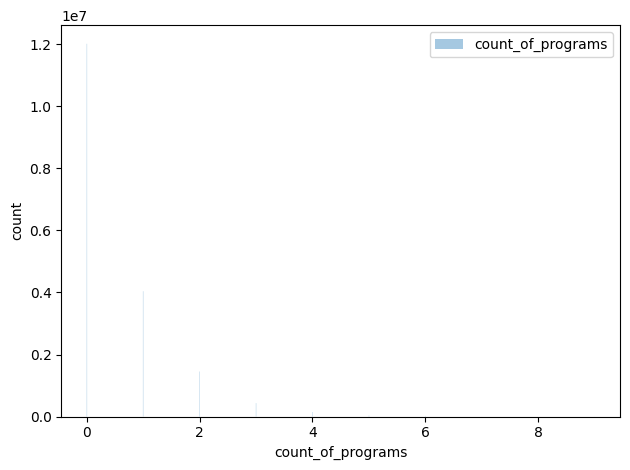

In [ ]:
plot_distribution(result, "count_of_programs", categorical, numerical)

Now let's work on recovery of missing values

In [ ]:
import polars as pl
from typing import Union

def count_empty_per_column(
    df: Union[pl.LazyFrame, pl.DataFrame]
) -> pl.DataFrame:
    is_lazy = isinstance(df, pl.LazyFrame)
    schema = df.collect_schema() if is_lazy else df.schema

    counts = {}
    for name, dtype in schema.items():
        if dtype == pl.Utf8:
            str_ns = pl.col(name).str

            if hasattr(str_ns, "strip"):
                trimmed = str_ns.strip()
            elif hasattr(str_ns, "replace_all"):
                trimmed = str_ns.replace_all(r'^\s+|\s+$', '')
            else:
                trimmed = str_ns.replace(r'^\s+|\s+$', "", literal=False)
            mask = pl.col(name).is_null() | (trimmed == "")
        else:
            mask = pl.col(name).is_null()

        expr = mask.sum().alias(name)
        if is_lazy:
            cnt = df.select(expr).collect()[0, name]
        else:
            cnt = df.select(expr)[0, name]
        counts[name] = cnt

    return pl.DataFrame(counts)


In [ ]:
counts = count_empty_per_column(df)

In [ ]:
long_df = counts.unpivot()
long_df.write_csv("empty_counts.csv")

In [ ]:

print(long_df)

shape: (128, 2)
┌─────────────────────────────────┬──────────┐
│ variable                        ┆ value    │
│ ---                             ┆ ---      │
│ str                             ┆ i64      │
╞═════════════════════════════════╪══════════╡
│ row_nr                          ┆ 0        │
│ Id                              ┆ 0        │
│ bySelf                          ┆ 0        │
│ companyID                       ┆ 0        │
│ corporateTariffCode             ┆ 9233925  │
│ frequentFlyer                   ┆ 12012727 │
│ nationality                     ┆ 0        │
│ isAccess3D                      ┆ 0        │
│ isVip                           ┆ 0        │
│ legs0_arrivalAt                 ┆ 0        │
│ legs0_departureAt               ┆ 0        │
│ legs0_duration                  ┆ 0        │
│ legs0_segments0_aircraft_code   ┆ 14       │
│ legs0_segments0_arrivalTo_airp… ┆ 114      │
│ legs0_segments0_arrivalTo_airp… ┆ 8        │
│ legs0_segments0_baggageAllowan… ┆ 1064    

In [ ]:
fill_df = (
    df
    .group_by("profileId")
    .agg(
        pl.col("frequentFlyer")
          .filter(pl.col("frequentFlyer").is_not_null())
          .first()
          .alias("ff_available")
    )
)

In [ ]:
df = (
    df
    .join(fill_df, on="profileId", how="left")
    .with_columns(
        pl.col("frequentFlyer").fill_null(pl.col("ff_available"))
    )
    .drop("ff_available")
)

In [ ]:
df = df.with_columns(
    pl.col("frequentFlyer").is_null().alias("frequentFlyer_was_absent")
)

Now we need to add column "is_domestic"

In [ ]:
routes_df = (
    df.select("searchRoute")
      .unique()
      .with_columns(
          pl.col("searchRoute")
          .map_elements(is_domestic, return_dtype=pl.Boolean)  # применяем функцию
          .alias("is_domestic")
      )
)

df = (
    df.join(routes_df, on="searchRoute", how="left")
)

Now, we need to recover "frequentFlyer" values for users for which we are not able to perform it naively like above

Let's plot how many searches each user has done, each search has information about carrier, price and etc that can be aggregated for each user with empty "frequentFlyer" and then used to recover it

In [ ]:
res = (
    df
    .group_by("profileId")
    .agg(
        pl.col("requestDate").dt.date().n_unique().alias("distinct_request_days")
    )
).lazy()

print(f"Number of users:{res.lazy().select(pl.count()).collect().to_series()[0]}")

/tmp/ipython-input-3195739995.py:9: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  print(f"Number of users:{res.lazy().select(pl.count()).collect().to_series()[0]}")


Number of users:32922


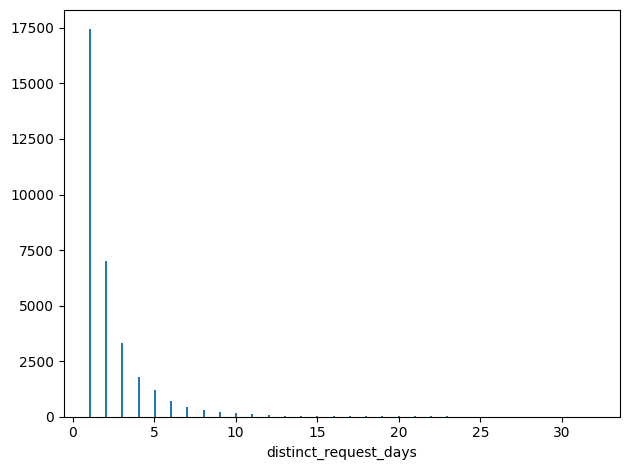

In [ ]:
plot_distribution(res, "distinct_request_days", categorical, categorical)

In [ ]:
print(f"Number of users which searched 1 time: {res.filter(pl.col('distinct_request_days') == 1).lazy().select(pl.count()).collect().to_series()[0]}")


/tmp/ipython-input-2870894048.py:1: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  print(f"Number of users which searched 1 time: {res.filter(pl.col('distinct_request_days') == 1).lazy().select(pl.count()).collect().to_series()[0]}")


Number of users which searched 1 time: 17437


In [ ]:
print(f"Number of users which searched 2 times: {res.filter(pl.col('distinct_request_days') == 2).lazy().select(pl.count()).collect().to_series()[0]}")


/tmp/ipython-input-2569439436.py:1: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  print(f"Number of users which searched 2 times: {res.filter(pl.col('distinct_request_days') == 2).lazy().select(pl.count()).collect().to_series()[0]}")


Number of users which searched 2 times: 7010


In [ ]:
print(f"Number of users which searched 3 times: {res.filter(pl.col('distinct_request_days') == 3).lazy().select(pl.count()).collect().to_series()[0]}")


/tmp/ipython-input-976538351.py:1: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  print(f"Number of users which searched 3 times: {res.filter(pl.col('distinct_request_days') == 3).lazy().select(pl.count()).collect().to_series()[0]}")


Number of users which searched 3 times: 3330


Maybe there's a companies where some employees have frequentFlyer column so we can use that info to recover values for other employees. Let's test this hypothesis

In [ ]:
res = df.group_by("companyID").agg(
    pl.col("profileId").n_unique().alias("num_employees")
)

Quantiles for 'num_employees' (df1):
  0%: 1.0
  25%: 2.0
  50%: 8.0
  75%: 32.0
  100%: 2390.0
----------------------------------------


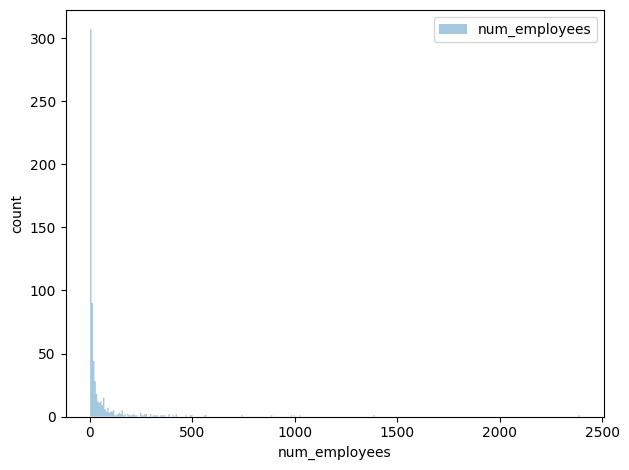

In [ ]:
plot_distribution(res, "num_employees", categorical, numerical+["num_employees"])

So, we have mostly small companies

Now let's count ratio of people with frequentFlyer_was_absent to overall number of employeers in ith company and plot this distr

In [ ]:
company_stats = (
    df
    .group_by(["companyID", "profileId"])
    .agg(pl.col("frequentFlyer_was_absent").max().alias("was_absent"))
    .group_by("companyID")
    .agg([
        pl.count("profileId").alias("num_employees"),
        pl.sum("was_absent").alias("num_absent"),
    ])
    .with_columns((pl.col("num_absent") / pl.col("num_employees")).alias("absent_ratio"))
)

company_stats_df = company_stats.collect()

In [ ]:
n_companies = df.select("companyID").unique().collect().height
print(f"Number of companies:{n_companies}")

Number of companies:641


In [ ]:
n_users = df.select("profileId").unique().collect().height
print(f"Number of users:{n_users}")

Number of users:32922


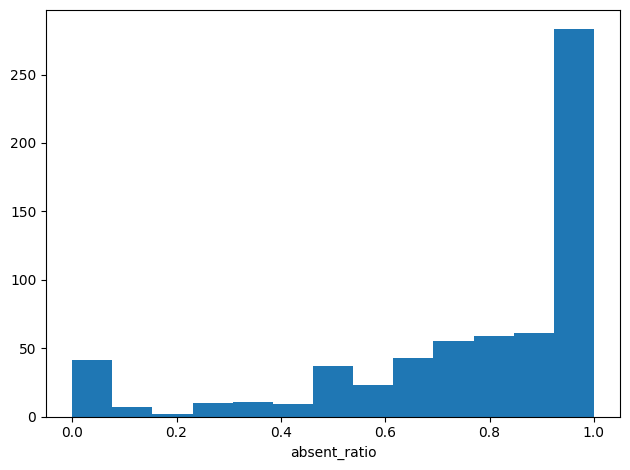

In [ ]:
plot_distribution(company_stats_df.lazy(), "absent_ratio", categorical, categorical)

In [ ]:
total_employees_df = (
    company_stats
    .filter(pl.col("absent_ratio") <= 0.9)
    .select(
        pl.col("num_employees").sum().alias("employees_in_selected_companies")
    )
    .collect()
)

recoverable = total_employees_df[0, "employees_in_selected_companies"]
print("Total employees that we can somehow recover(e.g absence of frequentFlyer <= 0.9):", recoverable)

total_employees_df = (
    company_stats
    .filter(pl.col("absent_ratio") <= 1)
    .select(
        pl.col("num_employees").sum().alias("employees_in_selected_companies")
    )
    .collect()
)
total_employees = total_employees_df[0, "employees_in_selected_companies"]
print("Total employees across companies:", total_employees)

Total employees that we can somehow recover(e.g absence of frequentFlyer <= 0.9): 21015
Total employees across companies: 33163


In [ ]:
print(n_users)
print(total_employees)

32922
33163


Number of unique profileId in df and sum of numbers of employees across companies is different then some users changed company, we need to account that, for example we can add bool feature "switched_company"

In [ ]:
profiles_multi_companies = (
    df
    .select(["profileId", "companyID"])        # берем только нужные колонки
    .unique()                                 # убираем дублирующиеся пары profileId–companyID
    .group_by("profileId")
    .agg([
        pl.col("companyID").n_unique().alias("num_companies"),  # сколько разных компаний
        pl.col("companyID").alias("company_list")               # список этих компаний
    ])
    .filter(pl.col("num_companies") > 1)       # только те, кто в >1 компании
)

num_profiles_multiple = (
    profiles_multi_companies
    .select(pl.count("profileId").alias("n_profiles"))
    .collect()
)[0, "n_profiles"]
print("Users associated with >1 company:", num_profiles_multiple)

Users associated with >1 company: 237


Introducing bool column changed_company:

In [ ]:
profiles_multi_companies = profiles_multi_companies.with_columns(
    (pl.col("company_list").list.len() > 1).alias("changed_company")
)

df = df.join(
    profiles_multi_companies.select(["profileId", "changed_company"]),
    on="profileId",
    how="left"
)

In [ ]:
print(recoverable / n_users)

0.638326954620011


Around 63% of users are in companies where other employees have "frequentFlyer" feature filled so we can calculate statistics per company to guide imputation model further

Also, let's observe distributions across people with frequentFlyer and without it

In [ ]:
lf_with_ff = (
    df.filter(pl.col("frequentFlyer").is_not_null())
    .select(["profileId", "nationality", "ranker_id"])
    .unique()
    .group_by("profileId")
    .agg([
        pl.first("nationality").alias("nationality"),
        pl.count("ranker_id").alias("search_count")
    ])
)


# Сессии для пользователей без frequentFlyer
lf_without_ff = (
    df.filter(pl.col("frequentFlyer").is_null())
    .select(["profileId", "nationality", "ranker_id"])
    .unique()
    .group_by("profileId")
    .agg([
        pl.first("nationality").alias("nationality"),
        pl.count("ranker_id").alias("search_count")
    ])
)


In [ ]:
print(lf_without_ff.fetch(100))

shape: (4, 3)
┌───────────┬─────────────┬──────────────┐
│ profileId ┆ nationality ┆ search_count │
│ ---       ┆ ---         ┆ ---          │
│ i64       ┆ i64         ┆ u32          │
╞═══════════╪═════════════╪══════════════╡
│ 2087904   ┆ 36          ┆ 1            │
│ 2384252   ┆ 36          ┆ 1            │
│ 2447853   ┆ 36          ┆ 1            │
│ 3382768   ┆ 36          ┆ 1            │
└───────────┴─────────────┴──────────────┘


/tmp/ipython-input-2734512033.py:1: DeprecationWarning: `LazyFrame.fetch` is deprecated. `LazyFrame.fetch` is deprecated; use `LazyFrame.collect` instead, in conjunction with a call to `head`.
  print(lf_without_ff.fetch(100))


In [ ]:
unique_nationalities = df.select(["nationality"]).unique().collect().to_numpy()
unique_nationalities = list(unique_nationalities.reshape(unique_nationalities.shape[0]));
unique_nationalities.sort()

Quantiles for 'search_count' (df1):
  0%: 1.0
  25%: 2.0
  50%: 3.0
  75%: 6.0
  100%: 53.0
----------------------------------------
Quantiles for 'search_count' (df2):
  0%: 1.0
  25%: 1.0
  50%: 2.0
  75%: 3.0
  100%: 52.0
----------------------------------------


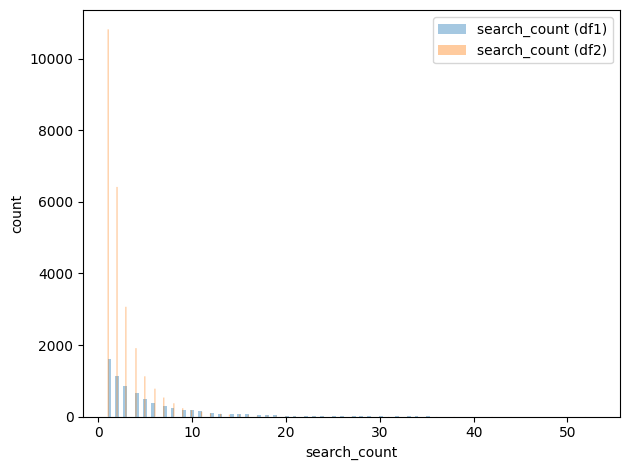

In [ ]:
plot_distribution([lf_with_ff, lf_without_ff], "search_count", categorical, numerical + ["search_count"], "auto")

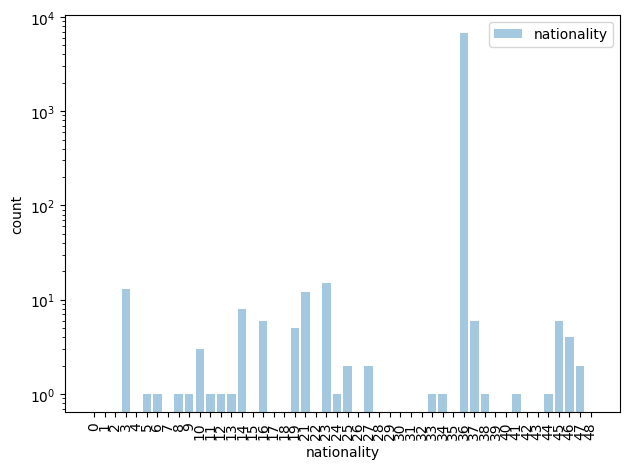

In [ ]:
plot_distribution(lf_with_ff, "nationality", categorical, numerical, "auto", logscale="y", category_order=unique_nationalities)

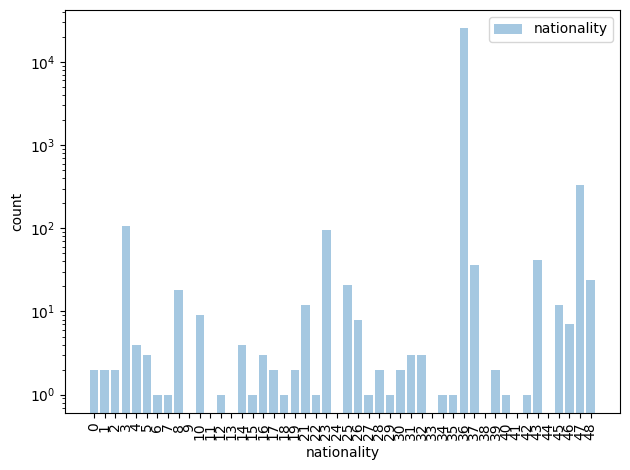

In [ ]:
plot_distribution(lf_without_ff, "nationality", categorical, numerical, "auto", logscale="y", category_order=unique_nationalities)

Nationalities 0,1,2,4,7,15,17,18,22,26,28,29,30,31,32,35,39,40,42,43,48 almost fully do not have "frequentFlyer". 36 stands for russian

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='frequentFlyer_was_absent', y='numeric_var', data=df)
plt.show()

In [ ]:
result = (
    df
    .group_by("companyID")
    .agg(
        pl.col("ranker_id").n_unique().alias("number_flights")
    )
)

result = result.collect()

Let's plot distrubution of number of flights inside each company

Quantiles for 'number_flights' (df1):
  0%: 1.0
  25%: 5.0
  50%: 23.0
  75%: 98.0
  100%: 6113.0
----------------------------------------


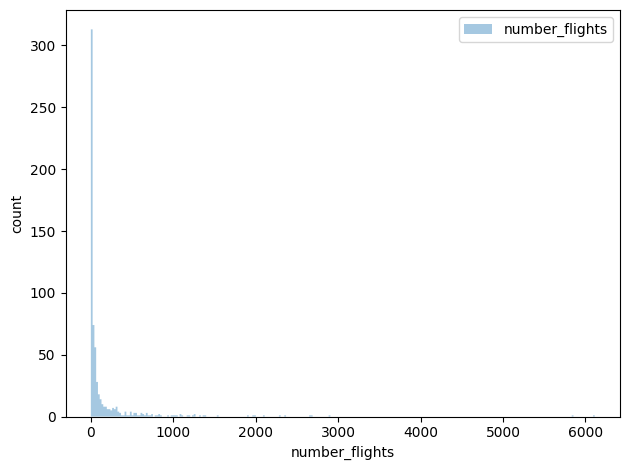

In [ ]:
plot_distribution(result, "number_flights", categorical, numerical + ["number_flights"], "auto")

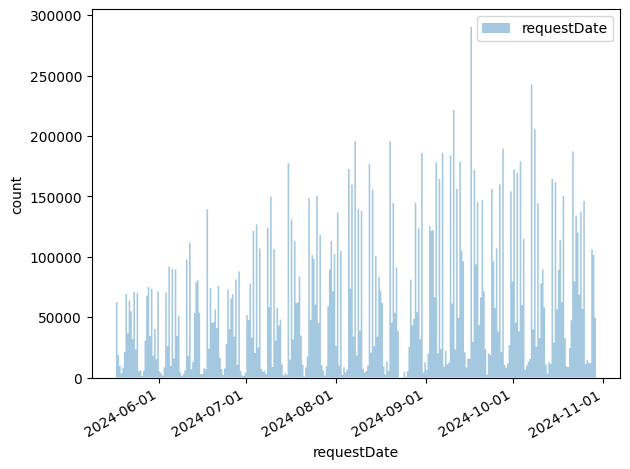

In [ ]:
plot_distribution(df, "requestDate", categorical, numerical, "auto")

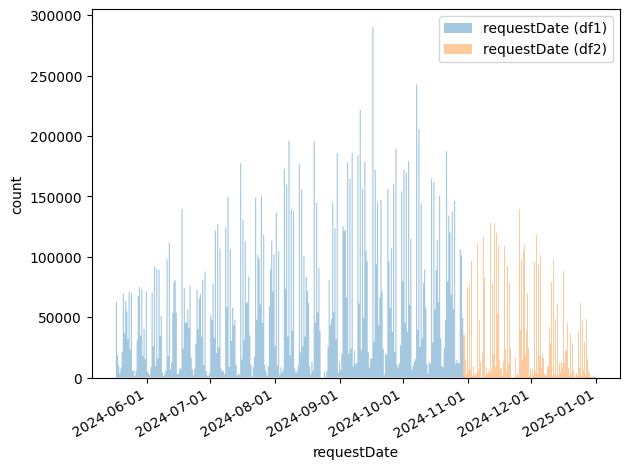

In [ ]:
plot_distribution([df, df_test], "requestDate", categorical, numerical, "auto")

There are week and month/seasons sesionality

In [ ]:
import polars as pl

# Assuming df and df_test are LazyFrames
df1 = df.select("companyID")  # Just keep companyID
df1_test = df_test.select("companyID")

# Collect unique company IDs from df into a Python set
company_ids_set = set(df1.collect().get_column("companyID").to_list())

# Get the list from df_test and check if all are in the set
test_ids = df1_test.collect().get_column("companyID").to_list()

all_present = all(x in company_ids_set for x in test_ids)

print(all_present)


True


In [ ]:
from __future__ import annotations
import argparse
from pathlib import Path
from typing import Dict, Tuple, Optional

import numpy as np
import polars as pl
import pandas as pd
import networkx as nx
from node2vec import Node2Vec
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score, label_ranking_average_precision_score, f1_score
from sklearn.preprocessing import normalize
from sklearn.multiclass import OneVsRestClassifier
from lightgbm import LGBMClassifier
import optuna
import joblib

pl.Config.set_tbl_formatting("ASCII_FULL")

# =============================
# Helpers: indices & utilities
# =============================

def _collect(lf: pl.LazyFrame) -> pd.DataFrame:
    return lf.collect().to_pandas()

# ---- Seasonal indices (global) ----

def build_S_dow(lf_search: pl.LazyFrame) -> pd.DataFrame:
    """Global day-of-week seasonal index S_dow(d) = n_d / median(n_*)."""
    return (
        lf_search
        .with_columns(pl.col("requestDate").dt.weekday().alias("dow"))
        .group_by("dow").agg(pl.len().alias("n"))
        .with_columns((pl.col("n")/pl.col("n").median()).alias("S_dow"))
        .select(["dow","S_dow"])
        .collect().to_pandas()
    )


def build_S_month(lf_search: pl.LazyFrame) -> pd.DataFrame:
    """Global month seasonal index S_month(m) = n_m / median(n_*)."""
    return (
        lf_search
        .with_columns(pl.col("requestDate").dt.month().alias("m"))
        .group_by("m").agg(pl.len().alias("n"))
        .with_columns((pl.col("n")/pl.col("n").median()).alias("S_month"))
        .select(["m","S_month"])
        .collect().to_pandas()
    )


# ---- Build long table of ALL legs/segments where cabinClass is present ----

def build_segments_long(lf_all: pl.LazyFrame, selected_only: bool = True) -> pl.LazyFrame:
    """Return lazyframe with columns [companyID, oper, cabin, dep] stacked over all legs/segments
    where a cabinClass column exists and is non-null. Departure time column is auto-detected.
    """
    cols = set(lf_all.collect_schema().names())
    lfs: list[pl.LazyFrame] = []
    base = lf_all.filter(pl.col("selected") == 1) if selected_only else lf_all

    for leg in (0, 1):
        for seg in (0, 1, 2, 3):
            c_col = f"legs{leg}_segments{seg}_cabinClass"
            op_col = f"legs{leg}_segments{seg}_operatingCarrier_code"
            dep_candidates = [
                f"legs{leg}_segments{seg}_departureFrom_time",
                f"legs{leg}_segments{seg}_departureAt",
                f"legs{leg}_departureAt",
                "requestDate",
            ]
            if c_col in cols:
                dep_col = next((d for d in dep_candidates if d in cols), "requestDate")
                exprs = [
                    pl.col("companyID"),
                    (pl.col(op_col) if op_col in cols else pl.lit(None)).alias("oper"),
                    pl.col(c_col).alias("cabin"),
                    pl.col(dep_col).alias("dep"),
                ]
                lfi = base.select(exprs).filter(pl.col("cabin").is_not_null())
                lfs.append(lfi)
    if not lfs:
        raise RuntimeError("No legs*_segments*_cabinClass columns found.")
    return pl.concat(lfs, how="vertical")


# ---- Route edge builder (searchRoute; DOW & Month; decay; TF–IDF) ----

def edges_route_from_search(
    lf_search: pl.LazyFrame,
    S_dow: pd.DataFrame,
    S_month: pd.DataFrame,
    tau_days: float = 173.0,   # ≈ h=120d
    beta: float = 0.1,
    gamma: float = 0.25,
    ref_date: Optional[str] = None,
) -> pd.DataFrame:
    # Parse routes and attach seasonal fields (compat with older Polars)
    lf = (
        lf_search
        .with_columns([
            pl.col("searchRoute").str.replace_all('"','').alias("sr"),
            pl.col("requestDate").alias("ts"),
        ])
        .with_columns(pl.col("sr").str.split("/").alias("sr_parts"))
        .explode("sr_parts")
        .with_columns([
            pl.col("sr_parts").alias("sr_part"),
            (pl.col("sr_parts").str.slice(0,3) + pl.lit("-") + pl.col("sr_parts").str.slice(3,3)).alias("route_id"),
            pl.col("ts").cast(pl.Utf8, strict=False).alias("ts_txt"),
        ])
        .with_columns([
            pl.col("ts_txt").str.strptime(pl.Datetime, strict=False, exact=False)
              .fill_null(pl.col("ts").cast(pl.Datetime, strict=False)).alias("ts_dt"),
        ])
        .with_columns([
            pl.col("ts_dt").dt.weekday().alias("dow"),
            pl.col("ts_dt").dt.month().alias("m"),
        ])
        .select(["companyID","route_id","totalPrice","ts_dt","dow","m"])
    )

    # Reference date for decay
    if ref_date is None:
        ref_val = lf.select(pl.col("ts_dt").max()).collect()[0,0]
    else:
        ref_val = ref_date
    import pandas as _pd
    ref_pydate = _pd.to_datetime(ref_val, errors="coerce").date()

    # robust age in days for older Polars: cast Date→Int (days since epoch)
    lf = lf.with_columns(
        (pl.lit(ref_pydate).cast(pl.Date).cast(pl.Int32) - pl.col("ts_dt").cast(pl.Date).cast(pl.Int32)).alias("age")
    )

    df = _collect(lf)
    # join seasonal multipliers
    df = df.merge(S_dow, on="dow", how="left").merge(S_month, on="m", how="left")
    # safety fills
    df["S_dow"] = df["S_dow"].fillna(1.0)
    df["S_month"] = df["S_month"].fillna(1.0)

    base = (1.0 / (df["S_dow"] * (df["S_month"]**gamma)))
    decay = np.exp(-df["age"].clip(lower=0) / max(tau_days, 1e-6))
    w = base * decay * beta * np.log1p(df["totalPrice"].astype(float).values)

    # aggregate
    agg = (
        pd.DataFrame({
            "companyID": df["companyID"].values,
            "route_id": df["route_id"].values,
            "w": w.values,
        })
        .groupby(["companyID","route_id"], as_index=False)["w"].sum()
    )

    # TF–IDF by route
    df_freq = agg.groupby("route_id")["companyID"].nunique()
    idf = np.log(len(df_freq) / (1 + df_freq))
    agg = agg.merge(idf.rename("idf"), left_on="route_id", right_index=True)
    agg["weight"] = agg["w"] * agg["idf"]
    return agg[["companyID","route_id","weight"]]

# ---- Carrier edges (selected options; DOW; decay; TF–IDF) ----

def edges_carrier_selected(
    lf_all: pl.LazyFrame,
    S_dow: pd.DataFrame,
    tau_days: float = 260.0,   # ≈ h≈180d
    alpha: float = 1.0,
    eta: float = 0.25,
    ref_date: Optional[str] = None,
) -> pd.DataFrame:
    # Use ALL legs/segments where cabinClass is present; selected itineraries only
    seg = build_segments_long(lf_all, selected_only=True)
    # keep rows where operating carrier is known
    seg = seg.filter(pl.col("oper").is_not_null())

    # parse dep → dep_dt robustly (Utf8 or already Datetime)
    seg = seg.with_columns([
        pl.col("dep").cast(pl.Utf8, strict=False).alias("dep_txt")
    ])
    seg = seg.with_columns(
        pl.col("dep_txt").str.strptime(pl.Datetime, strict=False, exact=False)
          .fill_null(pl.col("dep").cast(pl.Datetime, strict=False)).alias("dep_dt")
    )

    if ref_date is None:
        ref_val = seg.select(pl.col("dep_dt").max()).collect()[0,0]
    else:
        ref_val = ref_date
    import pandas as _pd
    ref_pydate = _pd.to_datetime(ref_val, errors="coerce").date()
    # age in days from dep_dt
    seg = seg.with_columns(
        (pl.lit(ref_pydate).cast(pl.Date).cast(pl.Int32) - pl.col("dep_dt").cast(pl.Date).cast(pl.Int32)).alias("age")
    )
    seg = seg.with_columns(pl.col("dep_dt").dt.weekday().alias("dow"))

    df = _collect(seg)
    df = df.merge(S_dow, on="dow", how="left")
    df["S_dow"] = df["S_dow"].fillna(1.0)

    is_biz = df["cabin"].isin([2.0, 4.0]).astype(float)
    base = (1.0 / (df["S_dow"]**eta))
    decay = np.exp(-df["age"].clip(lower=0) / max(tau_days, 1e-6))
    w = (1.0 + alpha * is_biz) * base * decay

    agg = (
        pd.DataFrame({"companyID": df["companyID"], "carrier": df["oper"], "w": w})
        .groupby(["companyID","carrier"], as_index=False)["w"].sum()
    )

    # TF–IDF by carrier
    df_freq = agg.groupby("carrier")["companyID"].nunique()
    idf = np.log(len(df_freq) / (1 + df_freq))
    agg = agg.merge(idf.rename("idf"), left_on="carrier", right_index=True)
    agg["weight"] = agg["w"] * agg["idf"]
    return agg[["companyID","carrier","weight"]]

# ---- Ticket-class edges (Empirical Bayes to bin prior) ----

def edges_class_empirical_bayes(
    lf_all: pl.LazyFrame,
    company_bins: pd.DataFrame,   # companyID, bin, m0
    priors: pd.DataFrame,         # bin, cabinClass, pi
) -> pd.DataFrame:
    # Use ALL legs/segments with non-null cabinClass on selected=1
    seg = build_segments_long(lf_all, selected_only=True)
    lf = seg.select(["companyID","cabin"]).group_by(["companyID","cabin"]).agg(pl.len().alias("n_ck"))
    cc = _collect(lf)
    Nc = cc.groupby("companyID")["n_ck"].sum().rename("N_c")
    cc = cc.merge(Nc, left_on="companyID", right_index=True)

    # attach bin & m0 and priors
    df = cc.merge(company_bins, on="companyID", how="left").merge(
        priors, on=["bin","cabin"], how="left"
    )
    df["pi"] = df["pi"].fillna(df.groupby("bin", observed=True)["pi"].transform("mean"))
    df["m0"] = df["m0"].fillna(25.0).astype(float)
    df["N_c"] = df["N_c"].astype(float)

    # s = m0/(N_c+m0); w = (1-s)*p_hat + s*pi
    s = df["m0"]/(df["N_c"] + df["m0"])
    w = (1 - s) * (df["n_ck"] / df["N_c"]) + s * df["pi"]

    out = df[["companyID","cabin"]].copy()
    out["weight"] = w
    return out

# ---- Graph + embeddings ----

def make_graph(edges_df: pd.DataFrame, left_col: str, right_col: str, left_prefix: str, right_prefix: str) -> nx.Graph:
    """Build a bipartite graph from an edges df. Columns must contain
    [left_col, right_col, 'weight']. Uses tuple iteration to avoid itertuples attr quirks.
    """
    G = nx.Graph()
    for left, right, w in edges_df[[left_col, right_col, "weight"]].itertuples(index=False, name=None):
        G.add_edge(f"{left_prefix}{left}", f"{right_prefix}{right}", weight=float(w))
    return G


def fit_node2vec(G: nx.Graph, dim: int, walk_length: int, num_walks: int, p: float, q: float, window: int):
    return (
        Node2Vec(G, dimensions=dim, walk_length=walk_length, num_walks=num_walks,
                 p=p, q=q, weight_key="weight", workers=4, seed=42)
        .fit(window=window, min_count=1, batch_words=1024)
    )


def extract_company_vectors(model, companies, prefix="C_") -> np.ndarray:
    dim = model.wv.vector_size
    out = np.zeros((len(companies), dim), dtype=np.float32)
    for i, cid in enumerate(companies):
        key = f"{prefix}{cid}"
        if key in model.wv:
            out[i] = model.wv[key]
    return out

# ---- Meta features per company (from selected=1) ----

def company_meta(lf_all: pl.LazyFrame) -> pd.DataFrame:
    # Segments with cabin present on selected itineraries
    seg = build_segments_long(lf_all, selected_only=True)
    lf_seg = (
        seg.group_by("companyID").agg([
            (pl.col("cabin").is_in([2.0,4.0]).mean()).alias("share_biz"),
            pl.len().alias("flights"),
        ])
    )
    # Mean price and HAS_FF pulled from original rows (selected=1)
    lf_base = (
        lf_all.filter(pl.col("selected")==1)
        .group_by("companyID").agg([
            pl.col("totalPrice").mean().alias("mean_price"),
            pl.when(
                pl.col("frequentFlyer").is_not_null() &
                (pl.col("frequentFlyer").cast(pl.Utf8, strict=False).str.len_chars() > 0)
            ).then(1).otherwise(0).max().alias("has_ff"),
        ])
    )
    lf = (
        lf_base.join(lf_seg, on="companyID", how="left")
        .with_columns(pl.col("flights").fill_null(0))
        .with_columns(pl.col("flights").log1p().alias("log_flights"))
    )
    return _collect(lf)

# ---- Priors & bins by company size ----

def build_bins_and_priors(lf_all: pl.LazyFrame, cut_edges: Optional[list[int]] = None) -> Tuple[pd.DataFrame,pd.DataFrame]:
    """Build size bins and class priors per bin.
    Here `num_employees` is created from the data as the number of unique `profileId` per company.
    """
    # 1) company → num_employees (n_unique profiles)
    comp_lf = (
        lf_all.select(["companyID", "profileId"])
             .unique()
             .group_by("companyID")
             .agg(pl.n_unique("profileId").alias("num_employees"))
    )
    comp = comp_lf.collect().to_pandas()
    comp["num_employees"] = comp["num_employees"].fillna(0).astype(int)

    # 2) binning by employees
    if cut_edges is None:
        cut_edges = [0, 2, 8, 32, 200, 10_000_000]
    comp["bin"] = pd.cut(comp["num_employees"], bins=cut_edges, include_lowest=True)

    # m0 per bin (robust to categories length)
    categories = list(comp["bin"].cat.categories)
    default_m0 = [50.0, 35.0, 25.0, 15.0, 10.0]
    m0_map = {cat: default_m0[i] if i < len(default_m0) else default_m0[-1]
              for i, cat in enumerate(categories)}
    comp["m0"] = comp["bin"].map(m0_map).astype(float)

    # 3) Priors π_k per bin using ALL legs (selected=1) where cabin is present
    seg = build_segments_long(lf_all, selected_only=True)
    df = _collect(seg.select(["companyID","cabin"]))
    df = df.merge(comp[["companyID","bin"]], on="companyID", how="left")
    g = df.groupby(["bin","cabin"], observed=True).size().rename("n").reset_index()
    N_bin = g.groupby("bin", observed=True)["n"].sum().rename("N_bin")
    g = g.merge(N_bin, on="bin")
    g["pi"] = g["n"]/g["N_bin"]
    priors = g[["bin","cabin","pi"]]

    bins = comp[["companyID","bin","m0"]]
    return bins, priors

# =============================
# FrequentFlyer multi-label utilities
# =============================

FF_MIN_COUNT = 500
FF_MIN_COMPANIES = 150


def parse_ff_codes(lf_all: pl.LazyFrame, selected_only: bool = True) -> pd.DataFrame:
    """Explode frequentFlyer strings to rows (companyID, code). Filters to 1–3 char A/Z/0–9.
    Returns pandas DataFrame.
    """
    lf = lf_all
    if selected_only:
        lf = lf.filter(pl.col("selected") == 1)
    lf = (
        lf.select(["companyID", "frequentFlyer"])
          .filter(pl.col("frequentFlyer").is_not_null())
          .with_columns(pl.col("frequentFlyer").cast(pl.Utf8, strict=False).str.replace_all('"','').alias("ff_txt"))
          .with_columns(pl.when(pl.col("ff_txt").str.len_chars() > 0).then(pl.col("ff_txt")).otherwise(None).alias("ff_txt"))
          .with_columns(pl.col("ff_txt").str.split("/").alias("ff_arr"))
          .explode("ff_arr")
          .with_columns(pl.col("ff_arr").str.strip_chars().str.to_uppercase().alias("code"))
          .filter(pl.col("code").is_not_null() & (pl.col("code").str.len_chars() <= 3) & (pl.col("code").str.len_chars() >= 1))
          .filter(pl.col("code").str.contains(r"^[A-Z0-9]{1,3}$", literal=False))
          .select(["companyID","code"])
    )
    return _collect(lf)


def build_ff_vocab(lf_all: pl.LazyFrame, min_count: int = FF_MIN_COUNT, min_companies: int = FF_MIN_COMPANIES) -> Tuple[list[str], pd.DataFrame]:
    df = parse_ff_codes(lf_all, selected_only=True)
    if df.empty:
        return [], pd.DataFrame(columns=["code","n","n_companies"])
    g = df.groupby("code").size().rename("n").reset_index()
    n_comp = df.drop_duplicates(["companyID","code"]).groupby("code").size().rename("n_companies").reset_index()
    vocab = g.merge(n_comp, on="code")
    vocab = vocab[(vocab["n"] >= min_count) & (vocab["n_companies"] >= min_companies)].sort_values("n", ascending=False)
    codes = vocab["code"].tolist()
    return codes, vocab


def build_company_code_matrix(lf_all: pl.LazyFrame, companies: np.ndarray, codes: list[str]) -> np.ndarray:
    """Return Y (n_companies, n_codes) binary matrix where Y[c,k]=1 if company c ever had code k."""
    if not codes:
        return np.zeros((len(companies), 0), dtype=np.uint8)
    df = parse_ff_codes(lf_all, selected_only=True)
    if df.empty:
        return np.zeros((len(companies), len(codes)), dtype=np.uint8)
    df = df.drop_duplicates()
    comp_index = {c:i for i,c in enumerate(companies)}
    code_index = {k:i for i,k in enumerate(codes)}
    Y = np.zeros((len(companies), len(codes)), dtype=np.uint8)
    # keep only rows with known company and code in vocab
    m = df["companyID"].isin(comp_index) & df["code"].isin(code_index)
    df = df[m]
    for c, k in df[["companyID","code"]].itertuples(index=False, name=None):
        Y[comp_index[c], code_index[k]] = 1
    return Y


def cv_multilabel_oof(X: np.ndarray, Y: np.ndarray, groups: np.ndarray, n_splits: int = 5,
                      base_estimator: Optional[LGBMClassifier] = None) -> Tuple[np.ndarray, dict]:
    """Return OOF probabilities (n_samples, n_labels) and per-label thresholds tuned on OOF (F1)."""
    if Y.shape[1] == 0:
        return np.zeros((len(X), 0), dtype=float), {}
    if base_estimator is None:
        base_estimator = LGBMClassifier(num_leaves=31, learning_rate=0.05, n_estimators=400, class_weight="balanced")
    gkf = GroupKFold(n_splits=n_splits)
    oof = np.zeros_like(Y, dtype=float)
    for tr, va in gkf.split(X, Y, groups):
        clf = OneVsRestClassifier(base_estimator)
        clf.fit(X[tr], Y[tr])
        proba = clf.predict_proba(X[va])
        # OneVsRest returns list when single label; normalize to 2D
        if isinstance(proba, list):
            proba = np.column_stack(proba)
        oof[va, :proba.shape[1]] = proba
    # thresholds per label by F1 on OOF
    thresholds = {}
    for k in range(Y.shape[1]):
        yk = Y[:,k]
        pk = oof[:,k]
        if yk.min() == yk.max():
            thresholds[k] = 0.5
            continue
        best_t, best_f1 = 0.5, -1.0
        for t in np.linspace(0.1, 0.9, 17):
            pred = (pk >= t).astype(int)
            f1 = f1_score(yk, pred, zero_division=0)
            if f1 > best_f1:
                best_f1, best_t = f1, t
        thresholds[k] = float(best_t)
    return oof, thresholds


def fit_multilabel_full(X: np.ndarray, Y: np.ndarray) -> OneVsRestClassifier:
    if Y.shape[1] == 0:
        # dummy empty classifier
        return OneVsRestClassifier(LGBMClassifier()).fit(X, np.zeros((len(X), 1)))
    clf = OneVsRestClassifier(LGBMClassifier(num_leaves=31, learning_rate=0.05, n_estimators=600, class_weight="balanced"))
    clf.fit(X, Y)
    return clf


def assemble_ff_string(proba_row: np.ndarray, codes: list[str], thresholds: dict, top_k: int = 1,
                        min_max: float = 0.2) -> str:
    """Turn probability vector into 'AA/BA' string using per-label thresholds and small-K policy.
    - If max prob < min_max ⇒ return '' (empty).
    - Pick top_k codes above their thresholds; if none, take argmax if ≥ min_max.
    """
    if proba_row.size == 0:
        return ""
    p = proba_row.copy()
    mx = float(p.max())
    if mx < min_max:
        return ""
    order = np.argsort(-p)
    chosen = []
    for idx in order:
        t = thresholds.get(int(idx), 0.4)
        if p[idx] >= t:
            chosen.append(codes[idx])
        if len(chosen) >= top_k:
            break
    if not chosen:
        chosen = [codes[order[0]]] if p[order[0]] >= min_max else []
    return "/".join(chosen)

# =============================
# End-to-end build + evaluate
# =============================

def build_embeddings(
    lf_all: pl.LazyFrame,
    dim_route=64, dim_carrier=32, dim_class=8,
    tau_route=173.0, tau_carrier=520.0,
    gamma_month=0.25, eta_dow=0.25,
) -> Tuple[np.ndarray,np.ndarray,np.ndarray,pd.DataFrame]:
    """Return (emb_route, emb_class, emb_carrier, meta_df) aligned by companyID."""
    # Frames
    lf_search = lf_all.select(["companyID","searchRoute","requestDate","totalPrice"])

    # Seasonal indices
    S_dow = build_S_dow(lf_search)
    S_month = build_S_month(lf_search)

    # Route edges
    e_route = edges_route_from_search(lf_search, S_dow, S_month,
                                      tau_days=tau_route, beta=0.1, gamma=gamma_month)

    # Carrier edges (selected)
    e_car = edges_carrier_selected(lf_all, S_dow, tau_days=tau_carrier, eta=eta_dow)

    # Class edges (EB)
    bins, priors = build_bins_and_priors(lf_all)
    e_cls = edges_class_empirical_bayes(lf_all, bins, priors)

    # Graphs → embeddings
    G_r = make_graph(e_route, "companyID", "route_id", "C_", "R_")
    G_a = make_graph(e_car, "companyID", "carrier", "C_", "A_")
    G_c = make_graph(e_cls, "companyID", "cabin", "C_", "CL_")

    M_r = fit_node2vec(G_r, dim_route, 40, 10, 1.0, 2.0, 5)
    M_a = fit_node2vec(G_a, dim_carrier, 40, 10, 1.0, 2.0, 5)
    M_c = fit_node2vec(G_c, dim_class, 40, 10, 1.0, 2.0, 5)

    # Company list from meta
    meta = company_meta(lf_all)
    companies = meta["companyID"].to_numpy()

    emb_r = extract_company_vectors(M_r, companies)
    emb_a = extract_company_vectors(M_a, companies)
    emb_c = extract_company_vectors(M_c, companies)

    return emb_r, emb_c, emb_a, meta


def build_features(meta: pd.DataFrame, emb_r: np.ndarray, emb_c: np.ndarray, emb_a: np.ndarray):
    emb = np.hstack([emb_r, emb_c, emb_a])
    emb = normalize(emb)
    X_meta = meta[["mean_price","share_biz","log_flights"]].to_numpy()
    X = np.hstack([emb, X_meta])
    groups = meta["companyID"].to_numpy()
    return X, groups


def cv_auc(X: np.ndarray, y: np.ndarray, groups: np.ndarray, n_splits: int = 5) -> float:
    gkf = GroupKFold(n_splits=n_splits)
    aucs = []
    for tr, va in gkf.split(X, y, groups):
        model = LGBMClassifier(num_leaves=31, learning_rate=0.05, n_estimators=300)
        model.fit(X[tr], y[tr])
        p = model.predict_proba(X[va])[:,1]
        aucs.append(roc_auc_score(y[va], p))
    return float(np.mean(aucs))

# =============================
# Optuna objective (light)
# =============================

def objective(trial: optuna.trial.Trial, lf_all: pl.LazyFrame):
    dim_route = trial.suggest_categorical("dim_route", [32,64,96])
    dim_carrier = trial.suggest_categorical("dim_carrier", [32,64])
    dim_class = trial.suggest_categorical("dim_class", [8,16])
    h_route = trial.suggest_categorical("h_route", [90,120,180,10_000])
    h_car = trial.suggest_categorical("h_car", [180,360,10_000])
    tau_route = h_route/np.log(2)
    tau_car = h_car/np.log(2)
    gamma = trial.suggest_categorical("gamma", [0.0,0.25,0.5])
    eta = trial.suggest_categorical("eta", [0.0,0.25])

    emb_r, emb_c, emb_a, meta = build_embeddings(
        lf_all, dim_route=dim_route, dim_carrier=dim_carrier, dim_class=dim_class,
        tau_route=tau_route, tau_carrier=tau_car, gamma_month=gamma, eta_dow=eta
    )
    print(emb_r[0:3])
    print(emb_c[0:3])
    print(emb_a[0:3])
    print(meta[0:3])
    X, groups = build_features(meta, emb_r, emb_c, emb_a)

    # Multi-label targets
    companies = meta["companyID"].to_numpy()
    codes, _ = build_ff_vocab(lf_all)
    Y = build_company_code_matrix(lf_all, companies, codes)
    oof, _ = cv_multilabel_oof(X, Y, groups, n_splits=5)
    # metric: LRAP
    lrap = label_ranking_average_precision_score(Y, oof) if Y.shape[1] > 0 else 0.0
    trial.set_user_attr("LRAP", lrap)
    return 1.0 - lrap

In [ ]:
def run_pipeline(df,
                 out_dir: str = "model_artifacts",
                 n_trials: int = 0,
                 min_code_count: int = FF_MIN_COUNT,
                 min_code_companies: int = FF_MIN_COMPANIES,
                 topk: int = 1,
                 pmin: float = 0.2):
    lf_all = df

    if n_trials > 0:
        study = optuna.create_study(direction="minimize")
        study.optimize(lambda tr: objective(tr, lf_all), n_trials=n_trials)
        print("Best 1-LRAP:", study.best_value)
        best = study.best_params
        h_route = best.get("h_route", 120)
        h_car = best.get("h_car", 360)
        dim_route = best.get("dim_route", 64)
        dim_carrier = best.get("dim_carrier", 32)
        dim_class = best.get("dim_class", 8)
        gamma = best.get("gamma", 0.25)
        eta = best.get("eta", 0.25)
    else:
        h_route, h_car = 120, 360
        dim_route, dim_carrier, dim_class = 64, 32, 8
        gamma, eta = 0.25, 0.25

    emb_r, emb_c, emb_a, meta = build_embeddings(
        lf_all,
        dim_route=dim_route, dim_carrier=dim_carrier, dim_class=dim_class,
        tau_route=h_route/np.log(2), tau_carrier=h_car/np.log(2),
        gamma_month=gamma, eta_dow=eta,
    )
    X, groups = build_features(meta, emb_r, emb_c, emb_a)

    # Build FF vocab and multilabel targets
    companies = meta["companyID"].to_numpy()
    codes, vocab = build_ff_vocab(lf_all, min_code_count, min_code_companies)
    Y = build_company_code_matrix(lf_all, companies, codes)

    # OOF calibration
    oof, thresholds = cv_multilabel_oof(X, Y, groups, n_splits=5)
    if Y.shape[1] > 0:
        lrap = label_ranking_average_precision_score(Y, oof)
        print(f"LRAP (OOF): {lrap:.4f}")
    else:
        print("No FF codes passed the frequency filters; skipping FF training.")

    # Final model on all
    clf = fit_multilabel_full(X, Y)

    # Predict per-company probabilities
    proba = clf.predict_proba(X)
    if isinstance(proba, list):
        proba = np.column_stack(proba)

    # Imputed strings per company
    imp_strings = [
        assemble_ff_string(proba[i], codes, thresholds, top_k=topk, min_max=pmin)
        for i in range(len(companies))
    ]
    out_df = pd.DataFrame({
        "companyID": companies,
        "imputed_frequentFlyer": imp_strings
    })

    Path(out_dir).mkdir(exist_ok=True, parents=True)
    # Save artifacts
    joblib.dump(clf, Path(out_dir)/"ff_ovr.pkl")
    np.save(Path(out_dir)/"companies.npy", companies)
    np.save(Path(out_dir)/"emb_route.npy", emb_r)
    np.save(Path(out_dir)/"emb_class.npy", emb_c)
    np.save(Path(out_dir)/"emb_carrier.npy", emb_a)
    joblib.dump({"codes": codes, "thresholds": thresholds, "vocab": vocab}, Path(out_dir)/"ff_meta.pkl")
    out_df.to_csv(Path(out_dir)/"imputed_ff_per_company.csv", index=False)

    print("Saved model & embeddings to", out_dir)

run_pipeline(df, out_dir="/content/artifacts", n_trials=1)


[I 2025-08-10 19:20:17,224] A new study created in memory with name: no-name-f3de43a7-a6b8-4ecf-b8f9-4551281fa948


Computing transition probabilities:   0%|          | 0/4425 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/782 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/644 [00:00<?, ?it/s]

[[ 1.1244915  -0.8536812   0.51359844  0.3865755   0.08313889 -1.0805725
   0.22775881 -0.5118358  -0.30315804  0.1655394   0.37817356  0.35510057
  -0.18340917 -0.44489413  0.6184716   0.5402052  -1.1683493  -0.19537647
  -0.5617836   0.2841113  -0.12352899  0.5793517   0.33353466 -0.67733353
  -0.15616609  0.5865546   0.19977707  0.4166647   0.11003225 -0.2025232
  -0.6954986   0.957743    0.5927744   0.9489942  -0.12634867  0.34915954
   0.6886236  -1.0836475   0.0933947  -0.02554307  0.35225233 -0.8843354
  -0.51483476  0.22958995  0.10718812 -1.5004917  -0.39702994  0.25309357
  -0.17176843 -0.15136355  0.01904172 -0.77628475 -1.046796    0.5364157
  -0.12084621 -0.9097473   0.3530371  -0.8931724  -0.3492888   0.20034829
  -0.12455786  0.23793605  0.3184674  -0.9599399 ]
 [-0.10504384 -0.22328877  0.2798378   0.1869884   0.12908086 -0.24755894
  -0.27345017  0.03940285 -0.4144892  -0.20451735  0.36583596 -0.2659089
   0.03906624 -0.1798729   0.05278438  0.2994703  -0.09524145  0.5

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 306, number of negative: 207
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001752 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18193
[LightGBM] [Info] Number of data points in the train set: 513, number of used features: 107
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 304, number of negative: 209
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18184
[LightGBM] [Info] Number of data points in the train set: 513, number of used features: 107
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 305, number of negative: 208
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18195
[LightGBM] [Info] Number of data points in the train set: 513, number of used features: 107
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-08-10 19:26:53,625] Trial 0 finished with value: 0.014820592823712953 and parameters: {'dim_route': 64, 'dim_carrier': 32, 'dim_class': 8, 'h_route': 180, 'h_car': 360, 'gamma': 0.5, 'eta': 0.25}. Best is trial 0 with value: 0.014820592823712953.


Best 1-LRAP: 0.014820592823712953


Computing transition probabilities:   0%|          | 0/4425 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/782 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/644 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 303, number of negative: 209
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18150
[LightGBM] [Info] Number of data points in the train set: 512, number of used features: 107
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 306, number of negative: 207
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18193
[LightGBM] [Info] Number of data points in the train set: 513, number of used features: 107
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 314, number of negative: 199
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18192
[LightGBM] [Info] Number of data points in the train set: 513, number of used features: 107
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 305, number of negative: 208
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18182
[LightGBM] [Info] Number of data points in the train set: 513, number of used features: 107
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LRAP (OOF): 0.9875
[LightGBM] [Info] Number of positive: 383, number of negative: 258
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22777
[LightGBM] [Info] Number of data points in the train set: 641, number of used features: 107
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Saved model & embeddings to /content/artifacts
